# Lição de Casa - Aula 9
Jean Carlos Mello Xavier Faria - 11259628

Leonardo Alves Amaral Torres   - 11261002

In [1]:
import tensorflow.keras as keras
from keras.datasets import mnist
import cv2
import numpy as np
import sys
import time
import matplotlib.pyplot as plt

Vamos criar uma função para realizar os deslocamentos de um pixel de cada imagem para norte, sul, leste e oeste.

In [2]:
def data_augmentation(data, resp):
    desloc_n = np.empty((data.shape))
    desloc_s = np.empty((data.shape))
    desloc_l = np.empty((data.shape))
    desloc_o = np.empty((data.shape))
    
    transform_o = np.float32([[1,0,-1], [0,1,0]])
    transform_l = np.float32([[1,0,1], [0,1,0]])
    transform_s = np.float32([[1,0,0], [0,1,1]])
    transform_n = np.float32([[1,0,0], [0,1,-1]])
    
    for i in range(data.shape[0]):
        desloc_o[i] = cv2.warpAffine(data[i], transform_o, (data.shape[2], data.shape[1]))
        desloc_l[i] = cv2.warpAffine(data[i], transform_l, (data.shape[1], data.shape[2]))
        desloc_s[i] = cv2.warpAffine(data[i], transform_s, (data.shape[1], data.shape[2]))
        desloc_n[i] = cv2.warpAffine(data[i], transform_n, (data.shape[1], data.shape[2]))
        
    data_desloc = np.append(data, desloc_o, axis = 0)
    data_desloc = np.append(data_desloc, desloc_l, axis=0)
    data_desloc = np.append(data_desloc, desloc_s, axis=0)
    data_desloc = np.append(data_desloc, desloc_n, axis=0)
    
    for i in range(4):
        resp = np.append(resp, np.array([resp]))
    return data_desloc, resp

In [3]:
# the data, split between train and test sets
(AX, ay), (QX, qy) = mnist.load_data()

In [4]:
ax=np.empty((AX.shape[0],14,14))
for i in range(AX.shape[0]):
    ax[i]=cv2.resize(AX[i],(14,14))
ax, ay = data_augmentation(ax, ay)
qx=np.empty((QX.shape[0],14,14))
for i in range(QX.shape[0]):
     qx[i]=cv2.resize(QX[i],(14,14))
qx, qy = data_augmentation(qx, qy)

Vamos criar duas funções para conseguirmos printar as 5 imagens lado a lado para conseguirmos verificar o pixel deslocado para cada caso.

In [5]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

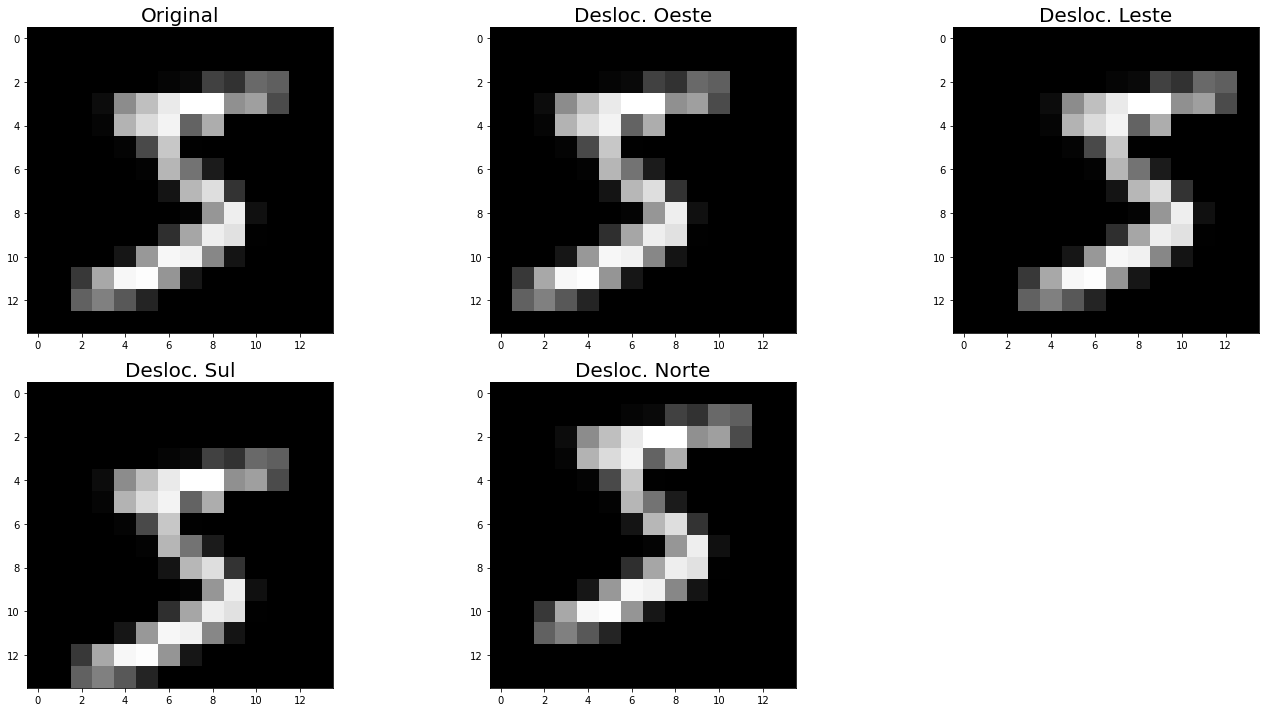

In [6]:
show_image_list(list_images=[ax[0], ax[60000], ax[120000], ax[180000], ax[240000]], 
                list_titles=['Original', 'Desloc. Oeste', 'Desloc. Leste', 'Desloc. Sul', 'Desloc. Norte'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)

Agora, vamos normalizar os dados

In [7]:
ax = ax.astype('float32')
qx = qx.astype('float32')
ax = ax.reshape(ax.shape[0],ax.shape[1]*ax.shape[2])
qx = qx.reshape(qx.shape[0],qx.shape[1]*qx.shape[2])
ax /= 255.0; #0 a 1
qx /= 255.0; #0 a 1
qp=np.empty(qy.shape,dtype="uint8")

Aplicando o FlaNN com 4 árvores

In [8]:
t1 = time.time()
FLANN_INDEX_KDTREE = 1; # bug: flann enums are missing
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 4)
flann = cv2.flann_Index(ax, flann_params)
t2 = time.time()
matches, dists = flann.knnSearch(qx, 1)
t3 = time.time()

Realizando a contagem dos erros

In [9]:
for l in range(matches.shape[0]):
    i=matches[l]
    qp[l]=ay[i]
erros=0
for l in range(matches.shape[0]):
     if qp[l]!=qy[l]: 
            erros+=1

In [10]:
print("Erros=%5.2f%%" % (100.0*erros/qy.shape[0]))
print("Tempo de treinamento: %f"%(t2-t1))
print("Tempo de predicao: %f"%(t3-t2))

Erros= 1.18%
Tempo de treinamento: 10.890707
Tempo de predicao: 2.552042
